# Analysis

This notebook contains routines for analyzing the output of keypoint-MoSeq, such as
- Annotating each recording with a group label
- Inspection and labeling of syllables
- Comparing syllable statistics across groups



```{note}
For the widgets below to work in a jupyter notebook, you must launch jupyter from a terminal in which the `keypoint_moseq` environment is active. You can double check by running `! which python` in the notebook. The output should be something like `/Users/username/miniconda3/envs/keypoint_moseq/bin/python`.
```

## Setup

We assume you have already have run keypoint-MoSeq, and that the outputs are organized as shown below.
```
.
└── <project_dir>/               ** current working directory
    ├── <model_dir>/             ** model directory
        ├── crowd_movies/        ** [Optional] crowd movies folder
        ├── grid_movies/         ** [Optional] grid movies folder
        ├── trajectory_plots/    ** [Optional] trajectory plots folder
        └── results.h5           ** model results
```

In [1]:
import keypoint_moseq as kpms

project_dir='demo_project' # the full path to the project directory
model_dirname='2023_05_23-15_19_03' # name of the model to analyze

Loading BokehJS ...

## Assign Groups

The following cell invokes an interactive spreadsheet widget that can be used to annotate each recording with a group label. These labels are important later on for performing group-wise comparisons. The annotations are saved to a to  `[project_dir]/index.yaml`.

- To assign a group label, select one or more rows, enter the group name and click `Set Group Name`
- Click the column headers to sort rows alphabetically, and click the filter icon in each column header to filter rows by name. 
- At any point, use `Update Index File` to save current group assignments.

In [2]:
index_file=kpms.interactive_group_setting(project_dir, model_dirname)

Button(description='Clear Output', style=ButtonStyle(), tooltip='Close Cell Output')

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## Generate dataframes

First generate a pandas dataframe called `moseq_df` that contains syllable labels and kinematic information for each frame across all the recording sessions. 

In [3]:
moseq_df = kpms.compute_moseq_df(project_dir, model_dirname) 

print('Generated moseq_df with shape', moseq_df.shape)
moseq_df.head()

Generated moseq_df with shape (643911, 10)


,name,centroid_x,centroid_y,heading,velocity_px_s,syllable,syllables_reindexed,frame_index,group,onset
0,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exa...,249.538038,208.037126,-1.251714,0.000000,15,9,0,default,True
1,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exa...,247.151433,210.056701,-1.251714,93.792917,15,9,1,default,False
2,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exa...,248.968059,209.160433,-1.276534,60.770742,15,9,2,default,False
3,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exa...,248.976926,206.677482,-1.276534,74.488994,15,9,3,default,False
4,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exa...,248.210082,204.428483,-1.277569,71.284239,15,9,4,default,False


In [4]:
import os
save_path = os.path.join(project_dir, model_dirname, 'moseq_df.csv')
moseq_df.to_csv(save_path, index=False)
print('Saved `moseq_df` dataframe to', save_path)

Saved `moseq_df` dataframe to demo_project/2023_05_23-15_19_03/moseq_df.csv


Next generate a dataframe called `stats_df` that contains summary statistics for each syllable in each recording session, such as its usage frequency and its distribution of kinematic parameters.

In [4]:
stats_df = kpms.compute_stats_df(
    moseq_df, 
    threshold=0.005,           # threshold frequency for including a syllable in the dataframe
    groupby=['group', 'name'], # column(s) to group the dataframe by
    fps=30                     # frame rate of the video from which keypoints were inferred
) 

print('Generated stats_df with shape', stats_df.shape)
stats_df.head()

Generated stats_df with shape (200, 13)


,group,name,syllable,frequency,duration,heading_mean,heading_std,heading_min,heading_max,velocity_px_s_mean,velocity_px_s_std,velocity_px_s_min,velocity_px_s_max
0,default,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exa...,0,0.033057,0.116243,0.354575,1.534550,-3.115259,3.133297,11.796958,8.501324,0.228988,76.316124
1,default,22_04_26_cage4_0.top.irDLC_resnet50_moseq_exam...,0,0.037093,0.116137,0.378436,1.939737,-3.138082,3.111661,11.595697,9.387771,0.069145,212.293414
2,default,22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_ex...,0,0.055989,0.122181,0.064307,1.694487,-3.141495,3.141379,12.669847,10.939616,0.105498,112.672517
3,default,22_04_26_cage4_1_1.top.irDLC_resnet50_moseq_ex...,0,0.034247,0.123631,-0.522997,1.631015,-3.139023,3.140993,11.315492,7.940800,0.354023,71.181844
4,default,22_27_04_cage4_mouse2_0.top.irDLC_resnet50_mos...,0,0.067254,0.135804,0.199815,1.732028,-3.141547,3.141338,12.121388,10.001572,0.207516,121.643678


In [6]:
import os
save_path = os.path.join(project_dir, model_dirname, 'stats_df.csv')
stats_df.to_csv(save_path, index=False)
print('Saved `stats_df` dataframe to', save_path)

Saved `stats_df` dataframe to demo_project/2023_05_23-15_19_03/stats_df.csv


## Fingerprint plot

Fingerprint plots show the distribution of syllable frequencies and kinematic parameters in each recording. The plot below is saved to `[project_dir]/[model_dirname]/analysis_figures`

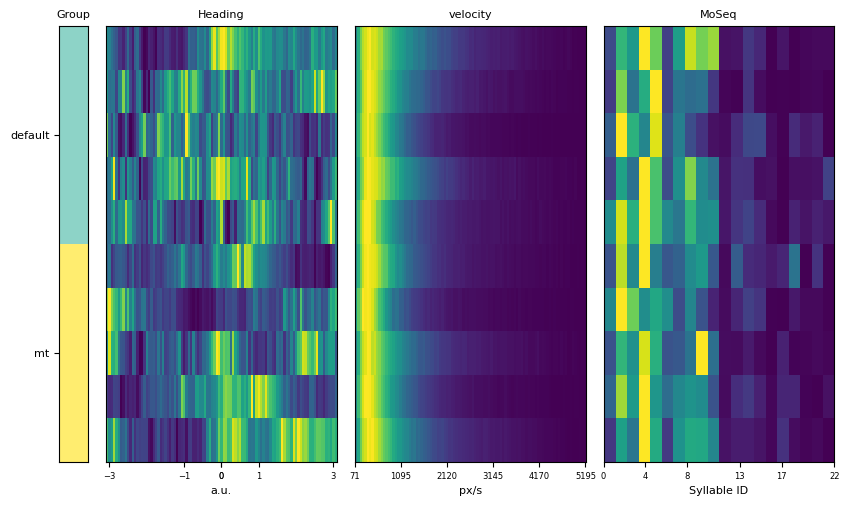

In [5]:
summary, range_dict = kpms.create_fingerprint_dataframe(moseq_df, stats_df, 
                                                        stat_type='mean', # the type of statistics to plot ("mean", "min", or "max")
                                                        n_bins=100, # the number fo bins that indicates resolution of distribution 
                                                        range_type='robust') # range type for stats, robust filters out top and bottom 1% ("robust" or "full")
kpms.plot_fingerprint(summary, range_dict, 
                      figsize=(10, 6), # the size of the figure
                      preprocessor_type='minmax') # data preprocessor for the fingerprint ("minmax", "standard", or "none")

##  Label syllables

Assign a name and short description to each syllable for downstream interpretation.

### Display trajectory plots

In [8]:
kpms.show_trajectory_gif(project_dir, model_dirname)

Image(value=b'GIF89aP\x05C\x07\x87\x00\x00\xff\xff\xff\xff\xff2\xfe\xfe\xfe\xfd\xfd\xfd\xfc\xfc\xfc\xfb\xfb\xf…

### Syllable labeling widget

In [5]:
kpms.label_syllables(project_dir, model_dirname, movie_type='grid') # `movie_type` can be "grid" or "crowd"


Loading BokehJS ...

Computing Syllable Statistics...


TypeError: compute_moseq_df() takes 2 positional arguments but 3 were given

## Compare between groups

Test for statistically significant differences between groups. The code below takes two groups (an experimental group and a control group) and a syllable property (e.g. frequency or duration), and tests each syllable for whether the property differs between groups. The results are summarized in a plot that is saved to `[project_dir]/[model_dirname]/analysis_figures`

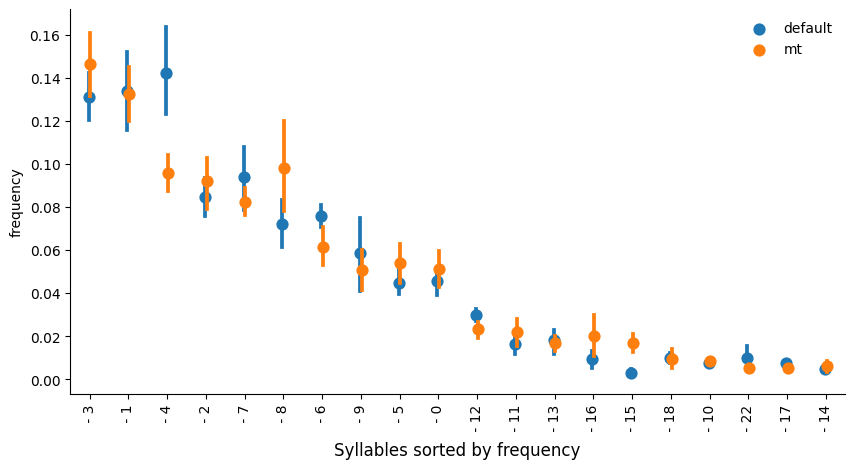

In [5]:
kpms.plot_syll_stats_with_sem(
    stats_df, project_dir, model_dirname, 
    plot_sig=True,    # whether to mark statistical significance with a star
    thresh=0.05,      # significance threshold
    stat='frequency', # statistic to be plotted ('duration' or 'velocity_px_s_mean')
    order='stat',     # order syllables by overall frequency ("stat") or degree of difference "diff"
    ctrl_group='a',   # name of the control group for statistical testing
    exp_group='b',    # name of the experimental group for statistical testing
    figsize=(10, 5),   # figure size    
    groups=stats_df['group'].unique(), # groups to be plotted
);                    


### Transition matrices
Plot heatmaps showing the transition frequencies between syllables.

Group(s): default, mt
maximum syllable to include: 20


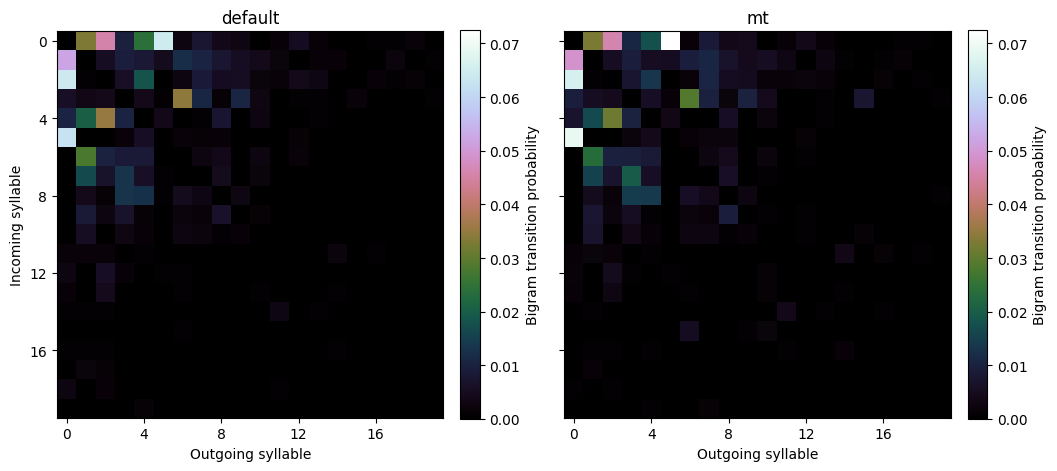

In [6]:
trans_mats, usages, groups=kpms.generate_transition_matrices(
    project_dir, model_dirname, 
    normalize='bigram', # normalization method ("bigram", "rows" or "columns")
    max_syllable=20)    # maximum number of syllables to include

kpms.visualize_transition_bigram(groups, trans_mats, 
                                 normalize='bigram') # matrix normalization methods ("bigram", "rows" or "columns")

### Syllable Transition Graph
Render transition rates as directed graphs, where each node represents one syllable, and the directional edges represent transitions between syllables. The code below first generates a transition graph for each single group, and then generates a difference-graph for each pair of groups.

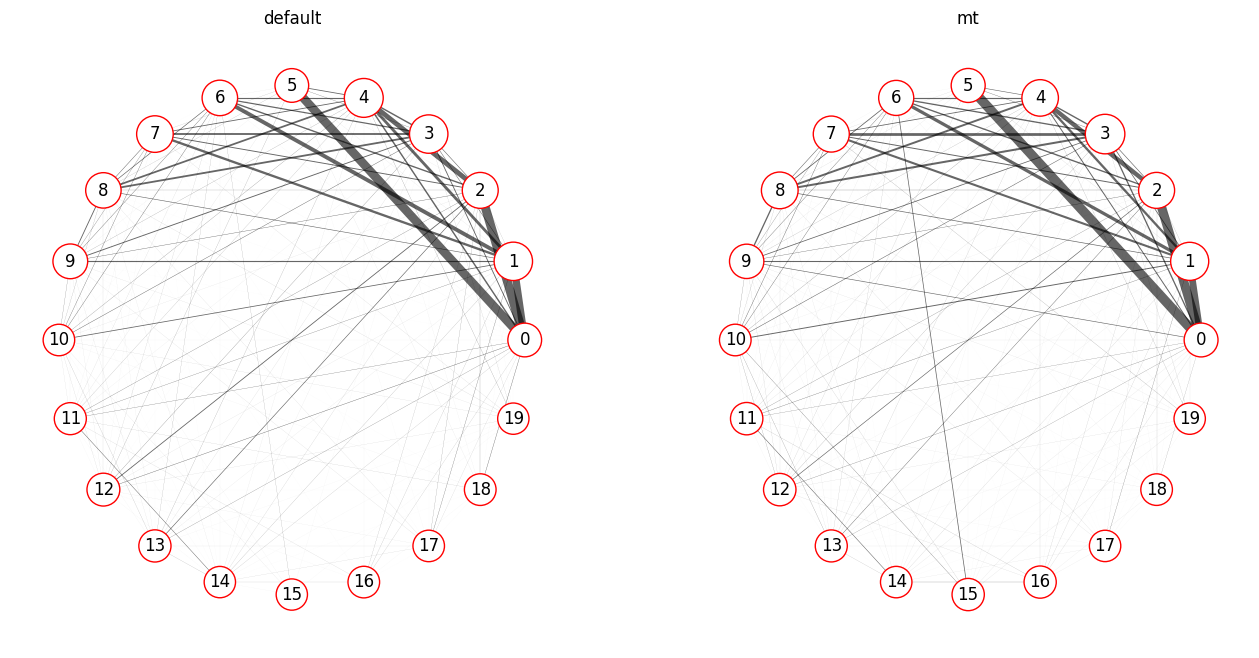

In [8]:
kpms.plot_transition_graph_group(groups, trans_mats, usages, 
                                 layout='circular') # transition graph layout ("circular" or "spring")

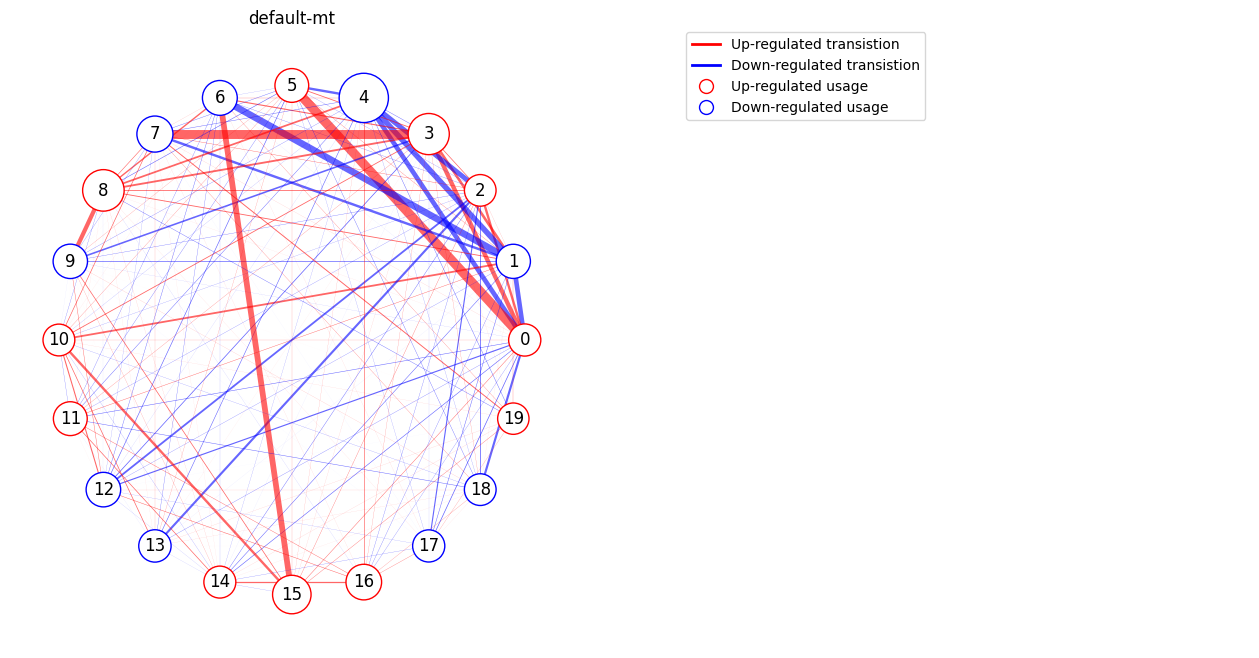

In [9]:
kpms.plot_transition_graph_difference(groups, trans_mats, usages, 
                                      layout='circular') # transition graph layout ("circular" or "spring")